In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import scipy.stats as sts
%matplotlib inline

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [5]:
#Среди channel_type есть пропущенные, я решила заполнить их дополнительным channel_type 'type_NA'
raw_df['channel_type'] =raw_df.channel_type.fillna(value = 'type_NA')
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,type_NA,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,type_NA,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,type_NA,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,type_NA,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,type_NA,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


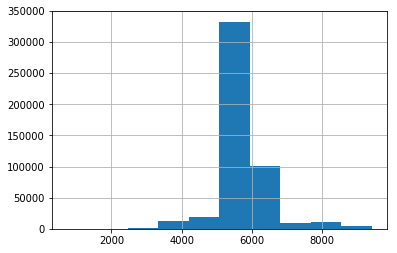

In [6]:
raw_df['MCC'].hist()

In [7]:
#не очень понятно, какие MCC популярные, но можно сказать, что визуально распределение похоже на нормальное

In [8]:
#Можно посмотреть топ-15 MCC
top_15_MCC=raw_df.groupby('MCC').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index().head(15)
top_15_MCC

,MCC,cl_id
0,5411,121640
1,6011,54382
2,5814,41351
3,5812,30027
4,5499,27237
5,5541,19816
6,5912,18728
7,5999,13073
8,6012,10056
9,5921,8578


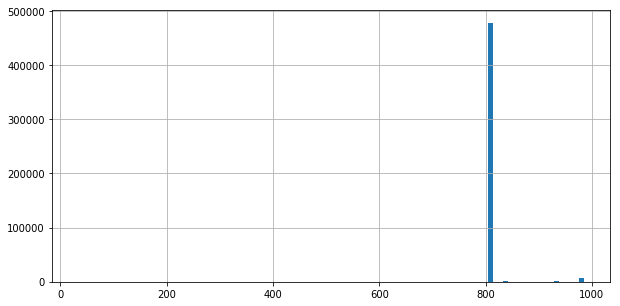

In [9]:
raw_df['currency'].hist(bins = 100,figsize=(10,5)) 

In [10]:
#Можно посмотреть топ-5 currency
top_5_currency=raw_df.groupby('currency').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index().head(5)
top_5_currency
#Рублевые операции - самые часто встречающиеся (как неожиданно)

,currency,cl_id
0,810,477644
1,978,5536
2,840,1921
3,933,561
4,985,423


In [11]:
#Топ trx_category
raw_df.groupby('trx_category').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index()
#С огромным перевесом лидируют pos транзакции. Я могу ошибаться, но скорее всего это транзакции по банковской карте.

,trx_category,cl_id
0,POS,416425
1,DEPOSIT,21216
2,WD_ATM_ROS,19104
3,WD_ATM_PARTNER,9948
4,C2C_IN,7306
5,WD_ATM_OTHER,7140
6,C2C_OUT,5456
7,BACK_TRX,2687
8,CAT,1197
9,CASH_ADV,34


In [12]:
raw_df.groupby('trx_category').sum()[['amount']].sort_values('amount', ascending=False).reset_index()

,trx_category,amount
0,POS,1.013062e+09
1,WD_ATM_ROS,6.680845e+08
2,DEPOSIT,4.827459e+08
3,WD_ATM_PARTNER,3.327178e+08
4,C2C_IN,9.989715e+07
5,C2C_OUT,8.807488e+07
6,WD_ATM_OTHER,7.478062e+07
7,BACK_TRX,2.461917e+07
8,CAT,2.260286e+07
9,CASH_ADV,9.128249e+05


In [13]:
#И больше всего денег приходится на pos операции

In [14]:
#Топ channel_type
raw_df.groupby('channel_type').count()[['cl_id']].sort_values('cl_id', ascending=False).reset_index()

,channel_type,cl_id
0,type1,299247
1,type2,175013
2,type5,5587
3,type4,4476
4,type3,3280
5,type_NA,2910


In [15]:
import datetime

In [16]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df

In [17]:
#В какие дни недели какой клиент чаще всего совершал транзакции
Popular_trans_d_for_cl_id=transaction_by_day_count(raw_df)
Popular_trans_d_for_cl_id.head()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0


In [18]:
#В какой день недели больше всего транзакций
Popular_trans_d_for_cl_id.sum()

day_of_transaction
cl_id    25561672.0
day_0       62114.0
day_1       65927.0
day_2       68509.0
day_3       69485.0
day_4       71458.0
day_5       78993.0
day_6       74027.0
dtype: float64

In [19]:
#больше всего совершается операций в субботу. Может люди чаще совершают оплаты картой (trx_category=POS) в субботу?

In [20]:
Popular_trans_d_for_cl_id_POS=transaction_by_day_count(raw_df[raw_df.trx_category=='POS'])
Popular_trans_d_for_cl_id_POS.head()

D:\Miniconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,1,5.0,20.0,19.0,16.0,16.0,10.0,15.0
2,5,14.0,16.0,14.0,7.0,19.0,19.0,22.0
3,9,5.0,4.0,5.0,4.0,4.0,3.0,4.0
4,10,67.0,29.0,43.0,59.0,55.0,47.0,74.0


In [21]:
Popular_trans_d_for_cl_id_POS.sum()

day_of_transaction
cl_id    25561672.0
day_0       55897.0
day_1       54598.0
day_2       57016.0
day_3       58084.0
day_4       59520.0
day_5       65654.0
day_6       65656.0
dtype: float64

In [22]:
#А нет, платят картами на выходных почти одинаково

In [23]:
#Если подумать, что сомнительно, что на отток клиентов будет влиять то, по каким дням они чаще совершают платежные операции

In [24]:
#Если я правильно понимаю, что trx_category - это вид транзакции, то от суммы по видам транзакций может зависеть, 
#отвалится клиент или нет. По крайней мере понимание, какими операциями клиенты пользуются чаще, и на какие операции 
#приходится основной денежный объем, поможет банку скорректировать предложения по банковским продуктам.

In [25]:
#На какой тип транзакций приходится самые большие суммы (по пользователяи)

In [26]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [27]:
df_agg_trx_category=get_aggregated_df(raw_df,'sum','trx_category').reset_index()
df_agg_trx_category.head()

trx_category,cl_id,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [28]:
#Теперь можно сгруппировать пользователей по cl_id

In [142]:
raw_df_grouped=raw_df[['cl_id', 'amount', 'target_flag']].groupby(['cl_id','target_flag']).sum().fillna(0).reset_index()
raw_df_grouped.head()

,cl_id,target_flag,amount
0,0,0,64383.00
1,1,0,267578.04
2,5,1,546369.13
3,9,0,849315.09
4,10,0,1124343.99


In [30]:
#И соединить сгруппированные данные raw_df_grouped с df_agg_trx_category

In [135]:
new_df_grouped=raw_df_grouped.merge(df_agg_trx_category, how = 'left', on = 'cl_id')
new_df_grouped.head()

,cl_id,target_flag,amount,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS
0,0,0,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,1,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [31]:
#И тут можно увидеть, как каждый пользователь был привлечен, на какую сумму у него были операции с разбивкой по видам транзакций

In [61]:
def transaction_by_month_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%m')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'month_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df

In [63]:
Popular_trans_m_for_cl_id=transaction_by_month_count(raw_df)
Popular_trans_m_for_cl_id.head()

day_of_transaction,cl_id,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,11.0,7.0,62.0,24.0,0.0,0.0
2,5,0.0,0.0,17.0,51.0,37.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0.0,0.0,0.0,0.0,17.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0
4,10,0.0,0.0,0.0,0.0,0.0,0.0,134.0,206.0,123.0,0.0,0.0,0.0


In [144]:
#здесь в channel_type количество операций на каждого пользователя всего
raw_df_grouped_count=raw_df[['cl_id', 'channel_type']].groupby(['cl_id']).count().fillna(0).reset_index()
raw_df_grouped_count.columns= ['cl_id','trans_count']
raw_df_grouped_count.head()

,cl_id,trans_count
0,0,5
1,1,104
2,5,142
3,9,39
4,10,463


In [146]:
new_df_grouped_all=new_df_grouped.merge(Popular_trans_m_for_cl_id, how = 'left', on = 'cl_id')
new_df_grouped_all.head()

,cl_id,target_flag,amount,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,0,0,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0
1,1,0,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,...,0.0,0.0,0.0,0.0,11.0,7.0,62.0,24.0,0.0,0.0
2,5,1,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,...,17.0,51.0,37.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,...,0.0,0.0,17.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0
4,10,0,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,...,0.0,0.0,0.0,0.0,134.0,206.0,123.0,0.0,0.0,0.0


In [147]:
new_df_grouped_all=new_df_grouped_all.merge(raw_df_grouped_count, how = 'left', on = 'cl_id')
new_df_grouped_all.head()

,cl_id,target_flag,amount,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,...,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,trans_count
0,0,0,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,5
1,1,0,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,...,0.0,0.0,0.0,11.0,7.0,62.0,24.0,0.0,0.0,104
2,5,1,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,...,51.0,37.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,142
3,9,0,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,...,0.0,17.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,39
4,10,0,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,...,0.0,0.0,0.0,134.0,206.0,123.0,0.0,0.0,0.0,463


In [156]:
cl_ids_test = np.random.choice(new_df_grouped_all.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [157]:
# данные для обучения
transactions_train = new_df_grouped_all[~new_df_grouped_all.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# данные для теста
transactions_test = new_df_grouped_all[new_df_grouped_all.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [158]:
#Тестовые
X_test = transactions_test.drop(['target_flag'], axis=1)
y_test = transactions_test['target_flag']

In [159]:
#Train
X_train = transactions_train.drop(['target_flag'], axis=1)
y_train = transactions_train['target_flag']

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [160]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [161]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train[cols], y_train)

In [162]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [163]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.83


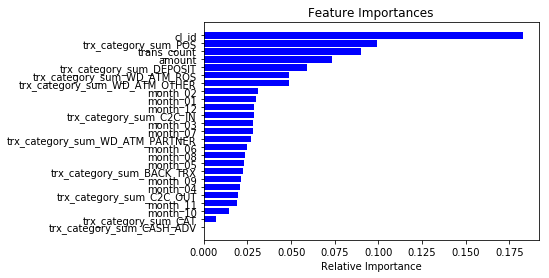

In [164]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [165]:
#без количества транзакци по месяцам

In [166]:
new_df_grouped_all_2=new_df_grouped.merge(raw_df_grouped_count, how = 'left', on = 'cl_id')
new_df_grouped_all_2.head()

,cl_id,target_flag,amount,trx_category_sum_BACK_TRX,trx_category_sum_C2C_IN,trx_category_sum_C2C_OUT,trx_category_sum_CASH_ADV,trx_category_sum_CAT,trx_category_sum_DEPOSIT,trx_category_sum_POS,trx_category_sum_WD_ATM_OTHER,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS,trans_count
0,0,0,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0,5
1,1,0,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0,104
2,5,1,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0,142
3,9,0,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0,39
4,10,0,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0,463


In [167]:
cl_ids_test_2 = np.random.choice(new_df_grouped_all_2.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set_2 = set(cl_ids_test_2)

In [168]:
# данные для обучения
transactions_train_2 = new_df_grouped_all_2[~new_df_grouped_all_2.cl_id.isin(cl_ids_test_2)].copy()
print("Total transactions in train dataset: ", len(transactions_train_2))
# данные для теста
transactions_test_2 = new_df_grouped_all_2[new_df_grouped_all_2.cl_id.isin(cl_ids_test_2)].copy()
print("Total transactions in test dataset: ", len(transactions_test_2))

Total transactions in train dataset:  4000
Total transactions in test dataset:  1000


In [169]:
#Тестовые
X_test_2 = transactions_test_2.drop(['target_flag'], axis=1)
y_test_2 = transactions_test_2['target_flag']

In [170]:
#Train
X_train_2 = transactions_train_2.drop(['target_flag'], axis=1)
y_train_2 = transactions_train_2['target_flag']

In [171]:
cols_2 = list(filter(lambda x: x in X_test_2.columns, X_train_2.columns))

In [172]:
clf_2 = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train_2[cols_2], y_train_2)

In [173]:
y_train_predict_2 = clf_2.predict_proba(X_train_2[cols_2])[:, 1]


roc_auc_train_2 = np.round(roc_auc_score(y_train_2, y_train_predict_2), 2)
print("Train: ", roc_auc_train_2)

Train:  1.0


In [174]:
y_test_predict_2 = clf_2.predict_proba(X_test_2[cols_2])[:, 1]


roc_auc_test_2 = np.round(roc_auc_score(y_test_2, y_test_predict_2), 2)
print("Test: ", roc_auc_test_2)

Test:  0.8


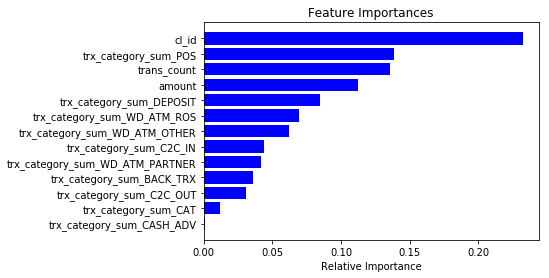

In [175]:
features = X_train_2.columns
importances = clf_2.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [176]:
#вторая модель без активности по месяцам предсказывает похуже